In [17]:
import numpy as np
import pandas as pd
# import os
# import nltk
# import random
# import torch
# from keras.layers.core import Dense, SpatialDropout1D
# from keras.layers.convolutional import Conv1D
# from keras.layers.embeddings import Embedding
# from keras.layers.pooling import GlobalMaxPooling1D
# from keras.models import Sequential
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils import np_utils
# from sklearn.model_selection import train_test_split
from gensim import utils
import gensim.parsing.preprocessing as gsp


In [18]:
df = pd.read_csv('data.csv')
df = df.drop(columns = ['Unnamed: 0'])
df.head()

,videoID,startTime,endTime,category,Sentence
0,fBxtS9BpVWs,41.00000,53.000000,sponsor,'Thanks to world of warships for sponsoring Th...
1,fBxtS9BpVWs,714.00000,763.000000,sponsor,'World of warships is a free-to-play historica...
2,1rb3bMvDdX4,588.94100,631.897770,sponsor,'location is a new risk - not just that it\nwi...
3,1rb3bMvDdX4,0.00000,6.861597,sponsor,'This video is sponsored by Dashlane. Protect ...
4,AM1-ecnQsm4,164.88225,206.000000,sponsor,"'""What is your favourite spelling of favorite?..."


In [19]:
filters = [gsp.strip_tags, gsp.strip_punctuation, gsp.strip_multiple_whitespaces, gsp.strip_numeric, gsp.remove_stopwords, gsp.strip_short, gsp.stem_text ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

for i in range(df.shape[0]):
  df['Sentence'][i] = clean_text(str(df['Sentence'][i]))

df.head()

C:\Users\ShabarishRamaswamy\AppData\Local\Temp\ipykernel_18004\2155674247.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentence'][i] = clean_text(str(df['Sentence'][i]))


,videoID,startTime,endTime,category,Sentence
0,fBxtS9BpVWs,41.00000,53.000000,sponsor,thank world warship sponsor video world warshi...
1,fBxtS9BpVWs,714.00000,763.000000,sponsor,world warship free plai histor onlin combat ga...
2,1rb3bMvDdX4,588.94100,631.897770,sponsor,locat new risk nwill fail
3,1rb3bMvDdX4,0.00000,6.861597,sponsor,video sponsor dashlan protect password free da...
4,AM1-ecnQsm4,164.88225,206.000000,sponsor,favourit spell favorit okai


In [20]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in df.iterrows():
    c = Counter(row['Sentence'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(25,10))
    bar_plot = sns.barplot(x=words, y=words_counts, palette='Paired')
    bar_plot.set_xlabel("Words",fontsize=20)
    bar_plot.set_ylabel("Frequency",fontsize=15)
    bar_plot.tick_params(labelsize=15)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

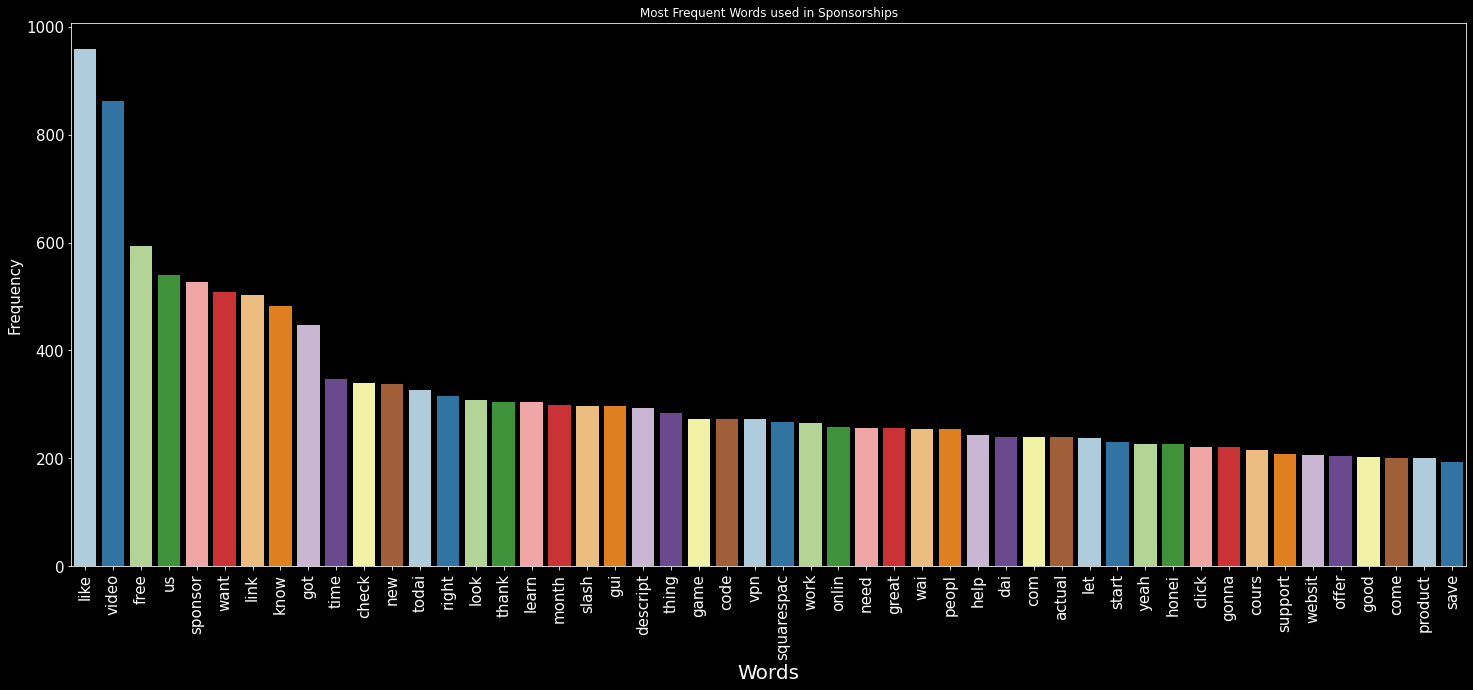

In [6]:
barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in Sponsorships')

In [7]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['sents']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['sents']).split())
                                     for index, row in df_x.iterrows()]))

In [8]:
dat = pd.DataFrame()
dat['sents'] = list(df.Sentence)
dat.head()

,sents
0,thank world warship sponsor video world warshi...
1,world warship free plai histor onlin combat ga...
2,locat new risk nwill fail
3,video sponsor dashlan protect password free da...
4,favourit spell favorit okai


In [22]:
doc2vec_tr = Doc2VecTransformer(vector_size=200)
doc2vec_tr.fit(dat)
doc2vec_vectors = doc2vec_tr.transform(dat)

100%|██████████| 1617/1617 [00:00<00:00, 1022492.02it/s]


In [23]:
from sklearn.neural_network import MLPRegressor

auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 600,
                                                 150, 
                                                 600,
                                               ))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

f:\Programming\FullStack\SponsEnd\venv\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
f:\Programming\FullStack\SponsEnd\venv\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
f:\Programming\FullStack\SponsEnd\venv\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warning

In [24]:
str(round(auto_encoder.score(predicted_vectors, doc2vec_vectors)*100,3))+'%'

f:\Programming\FullStack\SponsEnd\venv\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


'87.144%'

<AxesSubplot:>

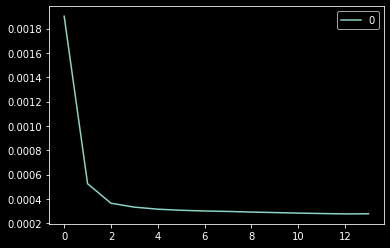

In [25]:
pd.DataFrame(auto_encoder.loss_curve_).plot()

In [26]:
data = ['todays video is sponsored by skillshare. Back to the video.','So my friend told me about her problems and I gave her some advice storytime','this video is sponsored by best fiends. it is a mobile multiplayer game that keeps you engaged.','i am a mukbang youtuber',"thank you raycon for sponsoring today's video",'we will be discussing this exam paper from Indias joint entrance exam','Use my coupon code EATMISS to get flat 30% off your first three purchases']
data = [clean_text(i) for i in data]
#data = [data[1]]
dd = pd.DataFrame()
dd['sents'] = data
data = dd
data

,sents
0,todai video sponsor skillshar video
1,friend told problem gave advic storytim
2,video sponsor best fiend mobil multiplay game ...
3,mukbang youtub
4,thank raycon sponsor todai video
5,discuss exam paper india joint entranc exam
6,us coupon code eatmiss flat purchas


In [27]:
dv = doc2vec_tr.transform(data)
pv = auto_encoder.predict(dv)

f:\Programming\FullStack\SponsEnd\venv\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [28]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(data)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=len(data)):
    for i in range(n):
        index, cosine_sim_val = sorted_cosine_similarities[i]
        cosine_sim_val = round(cosine_sim_val,4)
        print('Text Title: ', data.iloc[index][0])
        tag = ''
        if cosine_sim_val > 0.70:
          tag='Sponsored'
        else:
          tag='Content'
        print('Tag :', cosine_sim_val, tag)
        print('---------------------------------')

In [29]:
sorted_cosine_similarities = get_computed_similarities(vectors=dv, predicted_vectors=pv)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

Text Title:  discuss exam paper india joint entranc exam
Tag : 0.0008 Content
---------------------------------
Text Title:  mukbang youtub
Tag : 0.0562 Content
---------------------------------
Text Title:  todai video sponsor skillshar video
Tag : 0.8575 Sponsored
---------------------------------
Text Title:  video sponsor best fiend mobil multiplay game keep engag
Tag : 0.9864 Sponsored
---------------------------------
Text Title:  friend told problem gave advic storytim
Tag : 0.9957 Sponsored
---------------------------------
Text Title:  us coupon code eatmiss flat purchas
Tag : 0.9992 Sponsored
---------------------------------
Text Title:  thank raycon sponsor todai video
Tag : 1.0926 Sponsored
---------------------------------
